CAR FAC - Cascade of Asymmetric Resonators with Fast Acting Compression
===

The code below implements a model of the cochlea developed by Dick Lyon, which includes fast acting compression.

This notebook is based on Chapter 17 of his [Human and Machine Hearing book](http://www.machinehearing.org). Page numbers in the code comments refer to the pages of the Author’s 2018 corrected manuscript of this book.

Notebook by André van Schaik, [International Centre for Neuromorphic Systems](https://www.westernsydney.edu.au/icns).


Following on from the previous notebook on [the CAR model](http://nbviewer.ipython.org/github/vschaik/CARFAC/blob/master/CAR.ipynb), we now incorporate the Outer Hair Cell model in the Basilar membrane too. To do so, we update the BM resontator to look like this:

<img src="./images/BM-OHC.png" alt="BM-OHC" style="width: 600px;">

As before $X$ is the input of the section, coming from the sound source for the first section in the cascade, and from the output $Y$ of the previous section for each of the following sections.
$a_0$ and $c_0$ are are the coefficients of the filter, controlling the resonant frequency of each section. The resonant frequency will be highest for the first section and drop exponentially along the cochlea.
$h$ controls the distance between the poles and the zeros in the frequency domain.
$g$ adjusts the DC gain.

What is different is that now $r$, which controls the radius of the poles and zeros and thus the damping, is now modified online by the OHC model. First, the temporal derivative of the delayed imaginary part of the state variable is taken ($V[t-1] - V[t-2]$) to calculate the BM velocity $v$. This represents the local velocity of the BM. I don't know why $V[t-1] - V[t-2]$ is used, as opposed to, say $U[t] - U[t-1]$. This velocity signal is then passed through a nonlinear function:

$$\mathrm{NLF}(v)=\frac{1}{1+(v \cdot \text { scale }+ \text { offset })^2}$$

The output of this function is multiplied by $(1-b)$ where $b$ is a static parameter between 0 and 1 for the moment and then by $d_{rz}$. This signal then modifies $r$ from its minimum value $r_1$. The nonlinear function is such that $r$ increases as $v$ decreases.

$$r=r_1+d_{r z}(1-b) \mathrm{NLF}(v)$$


In [1]:
%matplotlib widget
from pylab import *
from scipy import signal

First let's set the stimulation parameters:

In [2]:
fs = 48000.0                        # sample frequency
dur = 2                             # simulation duration
npoints = int(fs * dur)             # stimulus length

Next, we create a log-sine-sweep using the *chirp* function from the *scipi.signal* library:

In [3]:
# create a log-sine-sweep
f0 = 20                             # sweep start frequency
f1 = 20000                          # sweep end frequency
t1 = arange(npoints) / fs           # sample times
gain = 1.0                          # gain of input signal
stimulus = gain * signal.chirp(t1, f0, t1[-1], f1, method='logarithmic', phi=-90)

Now we define the number of cochlear filters and the range of Basilar Membrane positions to spread these filters over with equal spacing.

In [4]:
nsec = 100                          # number of sections in the cochlea between
xlow = 0.1                          # lowest frequency position along the cochlea and
xhigh = 0.9                         # highest frequency position along the cochlea

Once all these parameters are defined, we can calculate the parameters for the CAR model. The frequencies of the resonators are spaced according to the Greenwood formula, while the damping controls the poles. The choice of $h = c_0$ sets the zeros for each section about half an octave above the location of the poles. $g$ is calculated to provide 0dB gain at DC.

In [5]:
x = linspace(xhigh, xlow, nsec)     # position along the cochlea 1 = base, 0 = apex
f = 165.4 * (10**(2.1 * x) - 1)     # Greenwood for humans
a0 = cos(2 * pi * f / fs)           # a0 and c0 control the poles and zeros
c0 = sin(2 * pi * f / fs)

damping = 0.2                       # damping factor
r = 1 - damping * 2 * pi * f / fs   # pole & zero radius (actual)
r1 = 1 - damping * 2 * pi * f / fs  # pole & zero radius minimum (set point)
h = c0                              # p285 h = c0 puts the zeros 1/2 octave above poles
g = (1 - 2 * a0 * r + r * r) / (1 - (2 * a0 - h * c0) * r + r * r)  
                                    # p285 this gives 0dB DC gain for BM

Now we also need parameters for the OHC part:

In [6]:
scale = 0.1                         # p297 NLF parameter
offset = 0.04                       # p297 NLF parameter
b = 1.0                             # automatic gain loop feedback (1=no undamping).
d_rz = 0.7 * (1 - r1)               # p294 relative undamping

From the block diagram at the top, we can see that the feedback signal is multiplied by $(1 - b)$ so that when $b = 1$, the feedback loop is effectively turned off. We'll start with this to verify that the code runs as in the previous notebook.

Before we run the simulation, we initialise the variables as needed.

In [7]:
W = zeros(nsec)                     # BM filter internal state
V = zeros(nsec)                     # BM filter internal state
Vold = zeros(nsec)                  # BM filter internal state at t-1
BM = zeros((nsec, npoints))         # BM displacement
BM[-1] = stimulus                   # put stimulus at BM[-1] to provide input to BM[0]

And we simulate the whole system for each sample time and for all cochlear sections.

In [9]:
for t in range(npoints):
    v_OHC = V - Vold
    Vold = V.copy()
    sqr = (v_OHC * scale + offset)**2
    NLF =  1 / (1 + (scale * v_OHC + offset)**2)
    r = r1 + d_rz * (1 - b) * NLF
    g = (1 - 2 * a0 * r + r * r) / (1 - (2 * a0 - h * c0) * r + r * r)
    for s in range(nsec):
        Wnew = BM[s - 1, t] + r[s] * (a0[s] * W[s] - c0[s] * V[s])
        V[s] = r[s] * (a0[s] * V[s] + c0[s] * W[s])
        W[s] = Wnew
        BM[s, t] = g[s] * (BM[s-1, t] + h[s] * V[s])


After playing the sweep signal through the cochlea, i.e., using it as the stimulus and simulating all time steps, we can get the frequency response and phase response of each cochlear filter by calculating:

In [10]:
# play the stimulus through the system and measure the output
output = BM

# use the FFT of the stimulus and output directly to calculate the transfer function
myFFT = fft(zeros((nsec, npoints)))
for s in range(nsec):
    myFFT[s] = (fft(output[s]) / fft(stimulus))
    

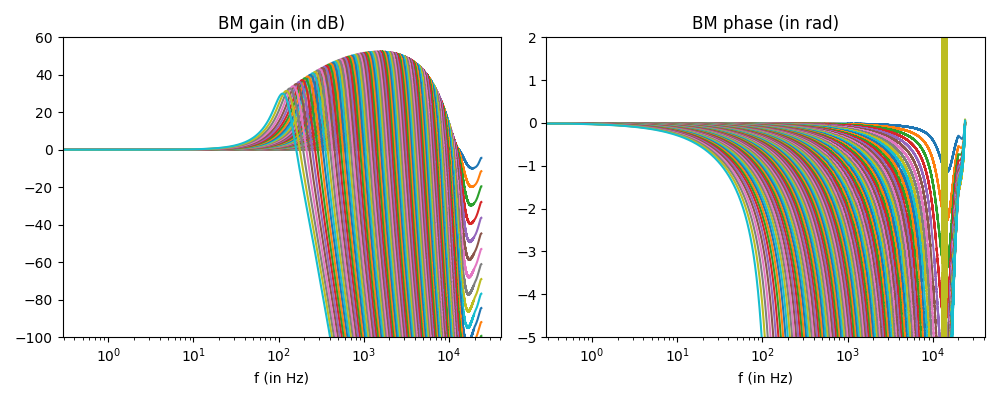

In [11]:
if fignum_exists(1): close(1)
fig1 = figure(1, figsize=(10, 4)) # Bode plot of BM displacement 
ax1 = fig1.add_subplot(1, 2, 1)
freq = linspace(0, fs // 2, npoints // 2)
semilogx(freq, 20 * log10(abs(myFFT.T[0 : npoints // 2, :]) + 1e-10))  
# note, 1e-10 offset to avoid division by zero in log10
title('BM gain (in dB)')
ylim([-100,60])
xlabel('f (in Hz)')
ax2 = subplot(1, 2, 2, sharex = ax1)
semilogx(freq, unwrap(angle(myFFT.T[0 : npoints // 2, :]), discont = 5, axis = 0))
title('BM phase (in rad)')
ylim([-5, 2])
xlabel('f (in Hz)')
tight_layout()

So indeed, the output looks as before without the OHCs. Now we will turn them on. Since the OHCs will reduce damping by increasing the radius of the poles and zeros, we will have to start with a much lower base radius and thus increase our initial damping. Also we will have to change the gain of the OHC feedback loop by controling $b$. Finally, in order to see the effect of the OHCs, we will need to play the input signal at different levels. Thus, the parameters we will play with are:

In [12]:
gain = 1.0                          # gain of input signal
b = 0.3                             # automatic gain loop feedback (1=no undamping).
damping = 0.4                       # damping factor

Here we have kept the input gain the same, activated the OHC loop with a gain of 0.7 and inceased the damping to 0.4. These changes mean we have to recalculate the following too:

In [13]:
stimulus = gain * signal.chirp(t1, f0, t1[-1], f1, method='logarithmic', phi=-90)
r = 1 - damping * 2 * pi * f / fs   # pole & zero radius (actual)
r1 = 1 - damping * 2 * pi * f / fs  # pole & zero radius minimum (set point)
g = (1 - 2 * a0 * r + r * r) / (1 - (2 * a0 - h * c0) * r + r * r)  
d_rz = 0.7 * (damping * 2 * pi * f / fs)  # relative damping

If we rerun the cochlea with these settings we get:

In [14]:
W = zeros(nsec)                     # BM filter internal state
V = zeros(nsec)                     # BM filter internal state
Vold = zeros(nsec)                  # BM filter internal state at t-1
BM = zeros((nsec, npoints))         # BM displacement
BM[-1] = stimulus                   # put stimulus at BM[-1] to provide input to BM[0]

for t in range(npoints):
    v_OHC = V - Vold
    Vold = V.copy()
    sqr = (v_OHC * scale + offset)**2
    NLF = 1 / (1 + (scale * v_OHC + offset)**2)
    r = r1 + d_rz * (1-b) * NLF
    g = (1 - 2 * a0 * r + r * r) / (1 - (2 * a0 - h * c0) * r + r * r)
    for s in range(nsec):
        Wnew = BM[s - 1, t] + r[s] * (a0[s] * W[s] - c0[s] * V[s])
        V[s] = r[s] * (a0[s] * V[s] + c0[s] * W[s])
        W[s] = Wnew
        BM[s, t] = g[s] * (BM[s-1, t] + h[s] * V[s])


As before we can divide the FFT of the time domain responses of each BM section by the FFT of the input signal, although this is no longer a correct transfer function, because the CARFAC model is no-longer a Linear-Time-Invariant system. However, it will do for illustration purposes.

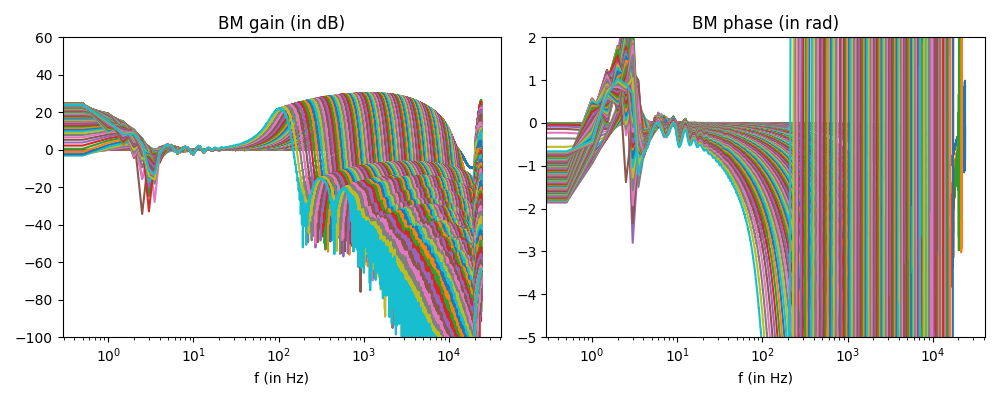

In [15]:
myFFT = fft(zeros((nsec, npoints)))
for s in range(nsec):
    myFFT[s] = (fft(BM[s]) / fft(stimulus))

if fignum_exists(2): close(2)
figure(2, figsize=(10, 4))          # Bode plot of BM displacement 
ax1 = subplot(1, 2, 1)
freq = linspace(0, fs // 2, npoints // 2)
semilogx(freq, 20 * log10(abs(myFFT.T[0 : npoints // 2, :])))
title('BM gain (in dB)')
ylim([-100, 60])
xlabel('f (in Hz)')
ax2 = subplot(1, 2, 2,sharex = ax1)
semilogx(freq,unwrap(angle(myFFT.T[0 : npoints // 2, :]), discont = 5, axis = 0))
title('BM phase (in rad)')
ylim([-5, 2])
xlabel('f (in Hz)')
tight_layout()


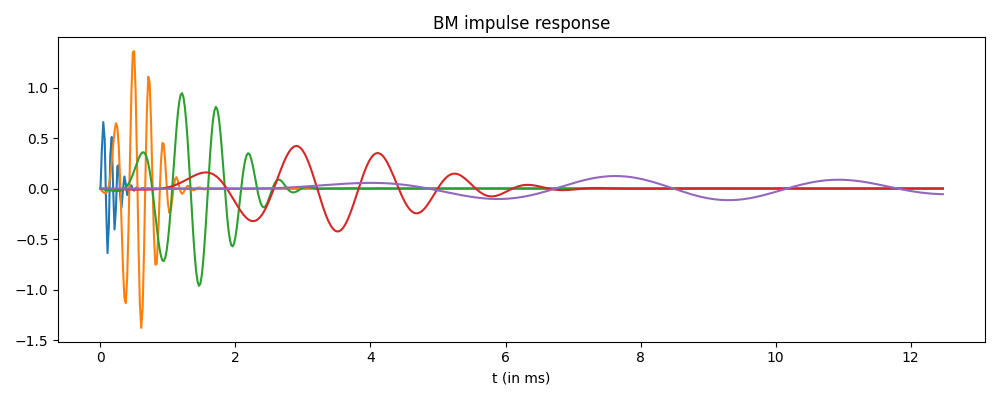

In [16]:
# calculate the BM impulse response
IR = real(ifft(myFFT))
IR[:, 0] = zeros(nsec)              # remove artefact

# plot only a few of the BM impulse responses
if fignum_exists(3): close(3)
figure(3, figsize=(10, 4))           # BM impulse response
L=600
plot(arange(L) * 1000 / fs, IR[5::20, 0 : L].T)
xlabel('t (in ms)')
title('BM impulse response')
tight_layout()

This shows reduced maximum gain compared with the version where the undamping is turned off and the damping is reduced. However, if we now reduce the level of the input signal we'll see that the gain increases:

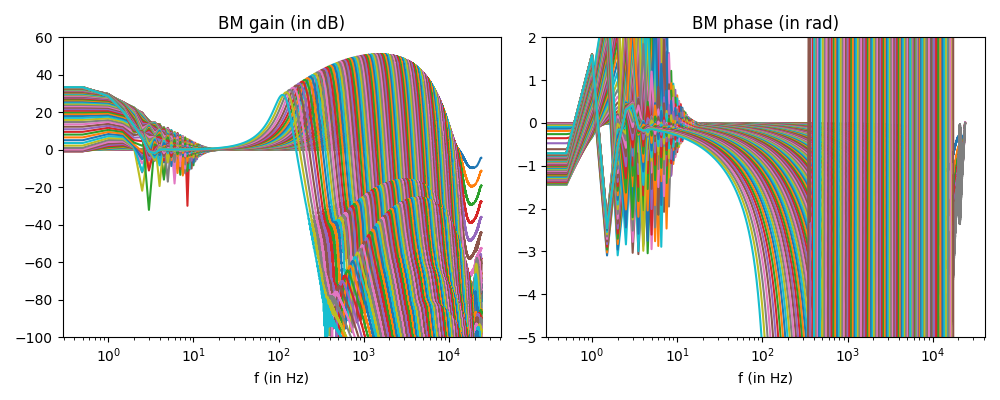

In [17]:
gain = 0.001                        # gain of input signal
b = 0.3                             # automatic gain loop feedback (1=no undamping).
damping = 0.4                       # damping factor

stimulus = gain * signal.chirp(t1, f0, t1[-1], f1, method='logarithmic', phi=-90)
r = 1 - damping * 2 * pi * f / fs   # pole & zero radius (actual)
r1 = 1 - damping * 2 * pi * f / fs  # pole & zero radius minimum (set point)
g = (1 - 2 * a0 * r + r * r) / (1 - (2 * a0 - h * c0) * r + r * r)  
d_rz = 0.7 * (damping * 2 * pi * f / fs)  # OHC gain

W = zeros(nsec)                     # BM filter internal state
V = zeros(nsec)                     # BM filter internal state
Vold = zeros(nsec)                  # BM filter internal state at t-1
BM = zeros((nsec, npoints))         # BM displacement
BM[-1] = stimulus                   # put stimulus at BM[-1] to provide input to BM[0]

for t in range(npoints):
    v_OHC = V - Vold
    Vold = V.copy()
    sqr =(v_OHC * scale + offset)**2
    NLF = 1 / (1 + (scale * v_OHC + offset)**2)
    r = r1 + d_rz * (1 - b) * NLF
    g = (1 - 2 * a0 * r + r * r) / (1 - (2 * a0 - h * c0) * r + r * r)
    for s in range(nsec):
        Wnew = BM[s - 1, t] + r[s] * (a0[s] * W[s] - c0[s] * V[s])
        V[s] = r[s] * (a0[s] * V[s] + c0[s] * W[s])
        W[s] = Wnew
        BM[s, t] = g[s] * (BM[s - 1, t] + h[s] * V[s])
    
myFFT = fft(zeros((nsec, npoints)))
for s in range(nsec):
    myFFT[s] = (fft(BM[s]) / fft(stimulus))

if fignum_exists(4): close(4)
fig = figure(4, figsize=(10, 4)) # Bode plot of BM displacement 
ax1 = subplot(1, 2, 1)
freq = linspace(0, fs / 2, npoints // 2)
semilogx(freq, 20 * log10(abs(myFFT.T[0: npoints // 2, :])))
title('BM gain (in dB)')
ylim([-100, 60])
xlabel('f (in Hz)')
ax2 = subplot(1, 2, 2,sharex = ax1)
semilogx(freq, unwrap(angle(myFFT.T[0 : npoints // 2, :]), discont = 5, axis = 0))
title('BM phase (in rad)')
ylim([-5, 2])
xlabel('f (in Hz)')
tight_layout()

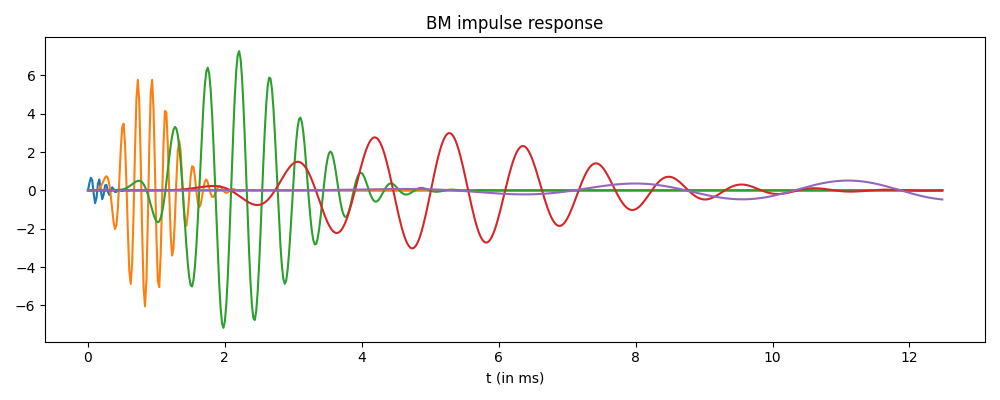

In [18]:
# calculate the BM impulse response
IR = real(ifft(myFFT))
IR[:, 0] = zeros(nsec)              # remove artefact

# plot only a few of the BM impulse responses
if fignum_exists(5): close(5)
figure(5, figsize=(10, 4))          # BM impulse response
L=600
plot(arange(L) * 1000 / fs, IR[5::20, 0 : L].T)
xlabel('t (in ms)')
title('BM impulse response')
tight_layout()

Next, we add the [Inner Hair Cells](./IHC.ipynb).